In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
style.use('default')
import quandl
from sklearn import linear_model as lm
from sklearn.metrics import mean_squared_error
import math
import statsmodels.tsa.arima_model as ar

C:\Users\manaj\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


#### Import CMT data from Qunadl

In [2]:
data = quandl.get("USTREASURY/YIELD", authtoken="")
data = data.drop('1 MO', 1)
# For Analysis period the 1 month CMT rates are often zero so drop 1 month Data

df = data.loc['2012-1-2':'2015-12-31']
df.head()

,3 MO,6 MO,1 YR,2 YR,3 YR,5 YR,7 YR,10 YR,20 YR,30 YR
Date,,,,,,,,,,
2012-01-03,0.02,0.06,0.12,0.27,0.40,0.89,1.41,1.97,2.67,2.98
2012-01-04,0.02,0.06,0.12,0.25,0.40,0.89,1.43,2.00,2.71,3.03
2012-01-05,0.02,0.07,0.11,0.27,0.40,0.88,1.43,2.02,2.74,3.06
2012-01-06,0.02,0.05,0.12,0.25,0.40,0.86,1.40,1.98,2.70,3.02
2012-01-09,0.01,0.05,0.11,0.26,0.38,0.85,1.39,1.98,2.70,3.02


##### For this assignment I drop 1 month data as many of the data points are zero or near zero 

In [3]:
# Array containing the list of maturities 
maturity = np.array([ 3/12, 6/12, 1.0, 2.0, 3.0, 5.0, 7.0, 10.0, 20.0, 30.0])

1. Step 1: Assume a value of $ \lambda $, and fit $ \beta_0$(t); $ \beta_1$(t); $ \beta_2$(t) to a set of yields observed on day t. (repeat for all days in the dataset)

#### Function to calculate $ \beta_0(t), \beta_1(t), and \beta_2(t)$ RMSE each day and Avg. R - squared over all the days in data frame for selected value of $\lambda$

In [4]:
def fit_NS_Parameters(l,df, maturity):
    
# Input:
#     Function Takes in 
#     l: lambda, 
#     df: CMT rates, and 
#     maturity: maturities of CMT rates 
# Output:
#     Returns in list form following:  
#     Avg R-squared over the period of analysis =Avgr2  
#     NS parameters:
#         beta_0 =regr_b0
#         beta_1 = regr_b1
#         beta_2 = regr_b2  
#     RMSE on Each day = rmse
#     Avg RMSE over the period of analysis = Avgrmse
 
    
    #calculating NS factor loadings for lambda and different maturity
    a2 = ((1-np.exp(-l*maturity))/(l*maturity))
    a3 = ((1-np.exp(-l*maturity))/(l*maturity) -np.exp(-l*maturity))

    #Creating dataframe for regression analysis
    a2a3 = np.array((a2,a3)).T
    X= pd.DataFrame(a2a3)

    #regression results for different days
    reg = lm.LinearRegression()
    regr_b0=[]
    #list of beta_0
    regr_b1 = []
    # list of beta_1
    regr_b2 = []
    # list of beta_2
    r2 = []
    # list of R-squared for model each day regression
    rmse = []
    # list of root mean squared errors each day
    
    #for loop to regress CMT data each day
    for date in df.index:
        
        y = df.loc[date]
        # y: Actual yeild for different maturities
        
        reg.fit(X=X,y=y)
        regr_b0.append(reg.intercept_)
        regr_b1.append(reg.coef_[0])
        regr_b2.append(reg.coef_[1])
        
        #Calculation of R-squared
        r2.append(reg.score(X,y))
        Avgr2 = np.mean(r2)
        
        # y_predict: yeild predicted by NS model regression
        y_predict = reg.predict(X)     
        
        #calculation of RMSE
        regression_model_mse = mean_squared_error(y,y_predict)
        mse = math.sqrt(regression_model_mse)
        rmse.append(mse)
        Avgrmse = np.mean(rmse)
         
         
    return Avgr2, regr_b0, regr_b1, regr_b2, rmse, Avgrmse

#### Function that plots yeild curve predicted by NS model

In [5]:
def ns_pltcurve(date, ns_factors, l, maturity, original_df, title = 'NS Model'):

# Input:
#     Function Takes in 
#     date: date to plot yeild curve, 
#     ns_factors: b0,b1,b2, 
#     lamda: lambda value to be used, and 
#     maturity: maturities of CMT rates 
#     original_df : original rates dataframe
#     with provision to edit title of graph
# Output:
#     Plot of yeild curve on specified day and 
#     plot of actual data on same graph
#     curve_: values of the yeilds on perticular maturity

    
    regr_result = ns_factors
    l = l
    maturity = maturity
    
    a2 = ((1-np.exp(-l*maturity))/(l*maturity))
    a3 = ((1-np.exp(-l*maturity))/(l*maturity) -np.exp(-l*maturity))
    a2a3 = np.array((a2,a3))
    
    #Calculation of predicted values
    cur = (regr_result[['b1','b2']].loc[date].reshape(2,1) * a2a3).T
    curve = np.sum(cur, axis=1)
    curve_ = curve + regr_result[['b0']].loc[date].values[0]
    
    #plot yeild curve
    plt.plot(maturity,curve_, label = title)
    plt.plot(maturity, original_df.loc[date], 'ro',label= 'Actual Data')
    plt.legend(loc = 4)
    plt.title(str(date)+' '+title+' Vs Actual Data')
    #plt.show()
    
    return curve_

def ns_curve(date, ns_factors, l, maturity, original_df, title = 'NS Model'):

# Input:
#     Function Takes in 
#     date: date to plot yeild curve, 
#     ns_factors: b0,b1,b2, 
#     lamda: lambda value to be used, and 
#     maturity: maturities of CMT rates 
#     original_df : original rates dataframe
#     with provision to edit title of graph
# Output:
#     Plot of yeild curve on specified day and 
#     plot of actual data on same graph
#     curve_: values of the yeilds on perticular maturity

    
    regr_result = ns_factors
    l = l
    maturity = maturity
    
    a2 = ((1-np.exp(-l*maturity))/(l*maturity))
    a3 = ((1-np.exp(-l*maturity))/(l*maturity) -np.exp(-l*maturity))
    a2a3 = np.array((a2,a3))
    
    #Calculation of predicted values
    cur = (regr_result[['b1','b2']].loc[date].reshape(2,1) * a2a3).T
    curve = np.sum(cur, axis=1)
    curve_ = curve + regr_result[['b0']].loc[date].values[0]
    return curve_
    

### Problem 1. Step 1: Assume a value of  $\lambda$, and $ \beta_0(t), \beta_1(t), and \beta_2(t)$ to a set of yields observed on day t (repeat for all days in the dataset)

C:\Users\manaj\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


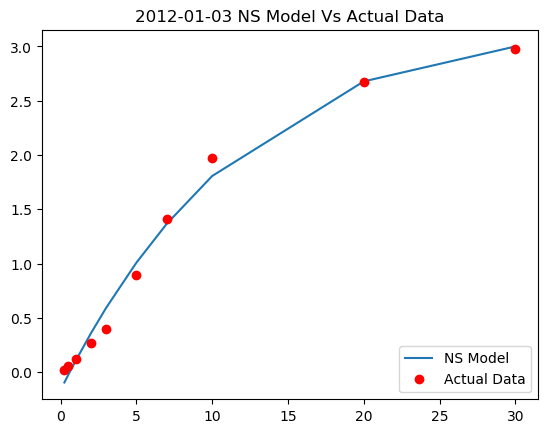

In [6]:
regr = fit_NS_Parameters(0.0609, df, maturity)
regr_result = pd.DataFrame(columns=['b0','b1','b2','Date','RMSE'])
regr_result['Date'] = df.index
regr_result.set_index('Date', inplace=True)
regr_result['b0'] = regr[1]
regr_result['b1'] = regr[2]
regr_result['b2'] = regr[3]
regr_result['RMSE'] = regr[4]

ns_pltcurve('2012-01-03', regr_result, 0.0609, maturity,df)
plt.show()

In [7]:
def list_ele_idx(li):
    # funtion that returns value index pairs in list
    return [(y,x) for x,y in enumerate(li)]

#### Function that returns optimal $\lambda$ and $ \beta_0(t), \beta_1(t), and \beta_2(t) $ values corresponding to optimal $\lambda$

In [8]:
def DNS_opt_lambda(lams, df, maturity):
    
# Input:
#     Function Takes in 
#     lams: list of lambdas to find optimal value among list, 
#     df: CMT rates, and 
#     maturity: maturities of CMT rates 
# Output:
#     Returns in list form following:
#     Optimal Lambda = l
#     NS parameters & RMSE each day corresponding to optimal lambda in dataframe = regr_result     

    
    maturity = maturity
    
    regr_b0 = []
    regr_b1 = []
    regr_b2 = []
    rmse = []
    Avgrmse = []
    
    # for loop to find optimal lambda
    for lam in lams:
        para = fit_NS_Parameters(lam,df,maturity)
        regr_b0.append(para[1])
        regr_b1.append(para[2])
        regr_b2.append(para[3])
        rmse.append(para[4])
        Avgrmse.append(para[5]) 
        
    # sort result in order of minimum RSME
    minrmse = list_ele_idx(Avgrmse)
    minrmse.sort()
    pos = minrmse[0][1]
    l = lams[pos]
    
    #Regression Results for optimal lambda
    regr_result = pd.DataFrame(columns=['b0','b1','b2','Date','RMSE'])
    regr_result['Date'] = df.index
    regr_result.set_index('Date', inplace=True)
    regr_result['b0'] = regr_b0[pos]
    regr_result['b1'] = regr_b1[pos]
    regr_result['b2'] = regr_b2[pos]
    regr_result['RMSE'] = rmse[pos]
    
    return l, regr_result

### Problem 1. Step 2: Find $\lambda$ that bests fits the whole dataset (Step1 needs to be repeated on each iteration; as you search for optimal $\lambda$). You can use an optimization package, or write your own code.

In [9]:
# Running DNS to find optimal lambda from sample of 95 values of lambda
lams = np.arange(0.05,0.8,0.01)
optimal_result = DNS_opt_lambda(lams,df,maturity)
# Estimated Running time about 1.3 min

#### Optimal $\lambda$

In [10]:
optimal_lambda = optimal_result[0]
optimal_lambda

0.45000000000000007

#### Optimal NS Parameters

In [11]:
ns_parameters = optimal_result[1]
ns_parameters.head()

,b0,b1,b2,RMSE
Date,,,,
2012-01-03,3.538519,-3.440374,-4.168066,0.041787
2012-01-04,3.603159,-3.501149,-4.292595,0.042264
2012-01-05,3.641773,-3.530930,-4.374767,0.046757
2012-01-06,3.590367,-3.483252,-4.331835,0.044559
2012-01-09,3.593300,-3.488854,-4.360374,0.048847


#### Yeild Curve using Optimal Parameters

C:\Users\manaj\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


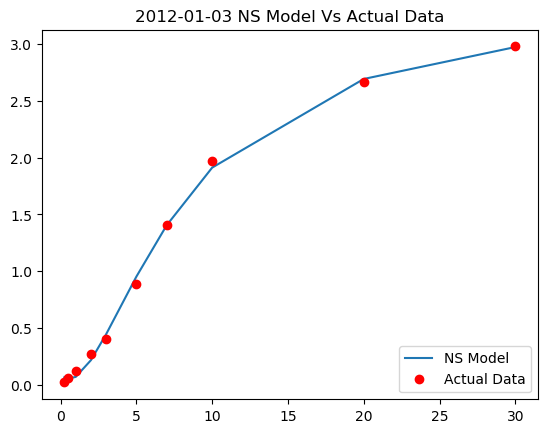

In [12]:
ns_pltcurve('2012-01-03', ns_parameters, optimal_lambda, maturity,df)
plt.show()

### Problem 2. Step 1: Compute RMSE for each day in the sample and pick 5 days with largest RMSE

In [13]:
RMSE_High2low = ns_parameters.sort_values('RMSE', ascending=False)
RMSE_High2low_Top5 = RMSE_High2low.head()
RMSE_High2low_Top5

,b0,b1,b2,RMSE
Date,,,,
2013-12-31,4.755711,-4.840431,-3.966636,0.134576
2013-12-24,4.670574,-4.761211,-3.818038,0.129626
2013-12-27,4.722743,-4.814582,-3.893853,0.129072
2014-01-02,4.705474,-4.785896,-3.954553,0.128512
2013-12-30,4.679239,-4.756223,-3.918479,0.127264


#### Plots of 5 Days with Highest RMSE

In [14]:
# for i in range(len(RMSE_High2low_Top5.index)):
#     date= RMSE_High2low_Top5.index[i].date()
#     ns_pltcurve(date, ns_parameters, optimal_lambda, maturity, df)
#     plt.show()

#### Function that calculates AR1 parameters and half-life of betas

In [15]:
def AR1_hf_fc_nsfactors(date, df_nsparameters, past_days, forcast_days):
    
# Input:
#     Function Takes in 
#     date: on which AR1 model ends
#     df_nsparameters: data frame containing betas corresponding to optimal lambda
#     past_days: number of days upto the date to be consider for analysis
#     forcast_days: number of forcasts to be generated  
# Output:
#     Returns in list form following:
#     half-life of the beats selected in sample = halflife
#     predicted values of beta based on fited AR1 model = predicted_betas
    
    #find index of the input date in dataframe
    ind = np.where(df_nsparameters.index==date)
    pos = ind[0][0]
    
    hf = []
    forcast = []
    cons_arparams = []
    
    #for loop to calculate AR1 model parameters and half-life
    for ns_factor in df_nsparameters.columns[:3]:
        b = df_nsparameters.iloc[pos-past_days:pos][ns_factor]
        #fit data using ARIMA(1,0,0) model in build function
        model = ar.ARIMA(b, order=(1,0,0)).fit()
        #print(model.summary()) 
        
        # half-life = -log(2)/log(slope_coeff_AR1)
        h = -math.log(2)/math.log(model.arparams)
        hf.append(h)
        
        forcast_b = model.forecast(forcast_days+1)[0]
        forcast.append(forcast_b)
    
    #Dataframe of forecasted Betas
    predicted_betas = pd.DataFrame(np.array(forcast).T)
    predicted_betas.columns = df_nsparameters.columns[:3]
    betas_index = df_nsparameters.iloc[pos:pos+forcast_days+1].index
    predicted_betas['Date'] = betas_index
    predicted_betas.set_index('Date', inplace=True)
    predicted_betas
    
    #Dataframe of half-life
    halflife = pd.DataFrame(columns=['Parameters', 'Half Life'])
    halflife['Parameters'] = df_nsparameters.columns[:3]
    halflife.set_index('Parameters', inplace = True)
    halflife['Half Life'] = hf
    
    return halflife, predicted_betas


### Feeling the Data Before Analysis:
###### I choose to visualize the time series of betas before we use AR1 model for prediction. The intent behind doing this is to analyze the effect of selection of past data to be used for AR1 analysis. More precisely I did this visual inspection to decide whether to consider calendar 6 months or 180 trading days. The graphs below are telling and so I choose to present results for both calendar 6 months and 180 trading days

#### Visual Inspection of NS Factor's time series

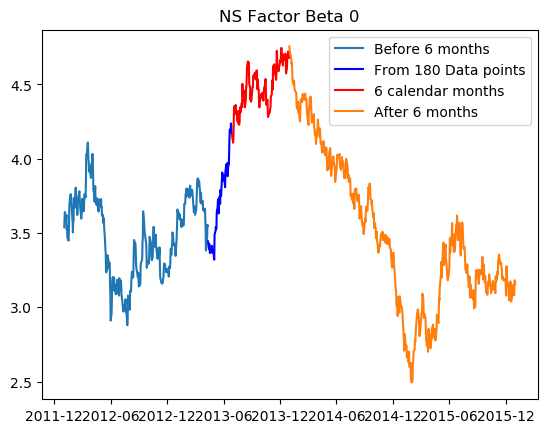

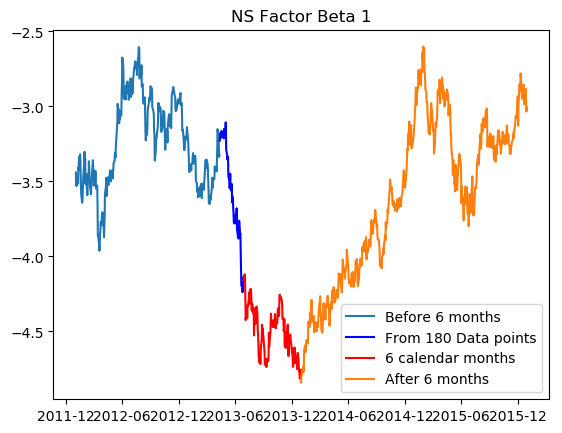

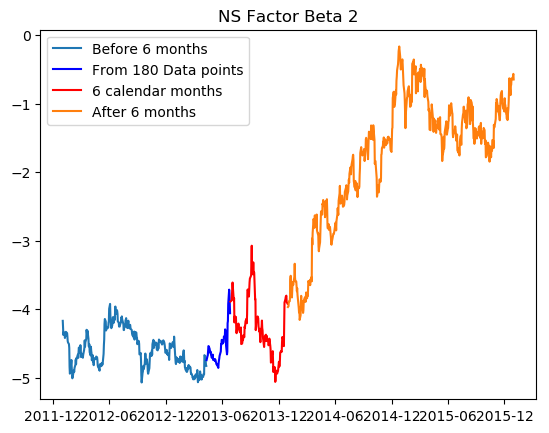

In [16]:
b0b1b2_a = ns_parameters.iloc[499-180:499-126]
b0b1b2_c = ns_parameters.iloc[499-126:499]
[plt.plot(ns_parameters[:499-180]['b0'], label= 'Before 6 months'),plt.plot(b0b1b2_a['b0'],'b', label = 'From 180 Data points'),plt.plot(b0b1b2_c['b0'],'r', label = '6 calendar months'),plt.plot(ns_parameters[499:]['b0'], label= 'After 6 months')]
plt.legend(loc=0)
plt.title('NS Factor Beta 0')
plt.show()

[plt.plot(ns_parameters[:499-180]['b1'], label= 'Before 6 months'),plt.plot(b0b1b2_a['b1'],'b', label = 'From 180 Data points'),plt.plot(b0b1b2_c['b1'],'r', label = '6 calendar months'), plt.plot(ns_parameters[499:]['b1'], label= 'After 6 months')]
plt.legend(loc=0)
plt.title('NS Factor Beta 1')
plt.show()

[plt.plot(ns_parameters[:499-180]['b2'], label= 'Before 6 months'),plt.plot(b0b1b2_a['b2'],'b', label = 'From 180 Data points'),plt.plot(b0b1b2_c['b2'],'r', label = '6 calendar months'), plt.plot(ns_parameters[499:]['b2'], label= 'After 6 months')]
plt.legend(loc=0)
plt.title('NS Factor Beta 2')
plt.show()

#### Problem 2. Step 2: Use 6m of data prior to each of the 5 days to fit AR(1) to each of $\lambda$ and $ \beta_0(t), \beta_1(t), and \beta_2(t) $ time series and co mpute half-lives (HL). Generate t+5d. t+10d, t+1m forecast for each of the 5 days, using the corresponding model for each forecast. Total of 3 forecasts for each of the 5 days.

### t+5d Half-life for 5 days

In [17]:
Predicted_beta_5d = []
half_life_5 = []
for date in RMSE_High2low_Top5.index:
    Predicted_5 = AR1_hf_fc_nsfactors(date, ns_parameters, 180, 5)
    Predicted_beta_5d.append(Predicted_5[1])
    half_life_5.append(Predicted_5[0])
    
Predicted_beta_5d_c = []
half_life_5_c = []
for date in RMSE_High2low_Top5.index:
    Predicted_5_c = AR1_hf_fc_nsfactors(date, ns_parameters, 126, 5)
    Predicted_beta_5d_c.append(Predicted_5_c[1])
    half_life_5_c.append(Predicted_5_c[0])

[print('\n 180 data points '+str(RMSE_High2low_Top5.index[i])+'\n',half_life_5[i]) for i in range(0,5)]
[print('\nCalendar 6 months '+str(RMSE_High2low_Top5.index[i])+'\n', half_life_5_c[i]) for i in range(0,5)]


 180 data points 2013-12-31 00:00:00
              Half Life
Parameters            
b0          126.859009
b1          139.156154
b2           16.954976

 180 data points 2013-12-24 00:00:00
              Half Life
Parameters            
b0          116.785062
b1          132.324984
b2           16.937142

 180 data points 2013-12-27 00:00:00
              Half Life
Parameters            
b0          105.778084
b1          122.561350
b2           18.140530

 180 data points 2014-01-02 00:00:00
              Half Life
Parameters            
b0          149.934950
b1          161.866876
b2           16.459938

 180 data points 2013-12-30 00:00:00
              Half Life
Parameters            
b0          111.241023
b1          128.718622
b2           17.539979

Calendar 6 months 2013-12-31 00:00:00
             Half Life
Parameters           
b0          12.634308
b1          10.602886
b2          15.467125

Calendar 6 months 2013-12-24 00:00:00
             Half Life
Parameters        

[None, None, None, None, None]

### t+5d Predicted Betas for 5 days

In [18]:
[print('\n 180 data points '+str(RMSE_High2low_Top5.index[i])+'\n',Predicted_beta_5d[i]) for i in range(0,5)]
[print('\nCalendar 6 months '+str(RMSE_High2low_Top5.index[i])+'\n', Predicted_beta_5d_c[i]) for i in range(0,5)]


 180 data points 2013-12-31 00:00:00
                   b0        b1        b2
Date                                    
2013-12-31  4.676209 -4.752774 -3.935339
2014-01-02  4.673197 -4.749341 -3.951524
2014-01-03  4.670200 -4.745926 -3.967061
2014-01-06  4.667220 -4.742527 -3.981975
2014-01-07  4.664256 -4.739146 -3.996291
2014-01-08  4.661309 -4.735781 -4.010035

 180 data points 2013-12-24 00:00:00
                   b0        b1        b2
Date                                    
2013-12-24  4.605475 -4.681275 -3.870451
2013-12-26  4.602431 -4.677833 -3.889377
2013-12-27  4.599404 -4.674409 -3.907543
2013-12-30  4.596395 -4.671003 -3.924982
2013-12-31  4.593404 -4.667615 -3.941721
2014-01-02  4.590430 -4.664244 -3.957789

 180 data points 2013-12-27 00:00:00
                   b0        b1        b2
Date                                    
2013-12-27  4.682104 -4.773691 -3.820977
2013-12-30  4.678716 -4.769923 -3.840488
2013-12-31  4.675350 -4.766177 -3.859268
2014-01-02  4.672007 -

[None, None, None, None, None]

### t+10d Predicted Betas for 5 days

In [19]:
Predicted_beta_10d = []

for date in RMSE_High2low_Top5.index:
    Predicted_10 = AR1_hf_fc_nsfactors(date, ns_parameters, 180, 10 )
    Predicted_beta_10d.append(Predicted_10[1])

Predicted_beta_10d_c = []
half_life_10_c = []
for date in RMSE_High2low_Top5.index:
    Predicted_10_c = AR1_hf_fc_nsfactors(date, ns_parameters, 126, 10)
    Predicted_beta_10d_c.append(Predicted_10_c[1])
    
[print('\n 180 data points '+str(RMSE_High2low_Top5.index[i])+'\n',Predicted_beta_10d[i]) for i in range(0,5)]
[print('\nCalendar 6 months '+str(RMSE_High2low_Top5.index[i])+'\n', Predicted_beta_10d_c[i]) for i in range(0,5)]


 180 data points 2013-12-31 00:00:00
                   b0        b1        b2
Date                                    
2013-12-31  4.676209 -4.752774 -3.935339
2014-01-02  4.673197 -4.749341 -3.951524
2014-01-03  4.670200 -4.745926 -3.967061
2014-01-06  4.667220 -4.742527 -3.981975
2014-01-07  4.664256 -4.739146 -3.996291
2014-01-08  4.661309 -4.735781 -4.010035
2014-01-09  4.658377 -4.732433 -4.023227
2014-01-10  4.655462 -4.729102 -4.035891
2014-01-13  4.652562 -4.725787 -4.048048
2014-01-14  4.649678 -4.722489 -4.059718
2014-01-15  4.646810 -4.719207 -4.070921

 180 data points 2013-12-24 00:00:00
                   b0        b1        b2
Date                                    
2013-12-24  4.605475 -4.681275 -3.870451
2013-12-26  4.602431 -4.677833 -3.889377
2013-12-27  4.599404 -4.674409 -3.907543
2013-12-30  4.596395 -4.671003 -3.924982
2013-12-31  4.593404 -4.667615 -3.941721
2014-01-02  4.590430 -4.664244 -3.957789
2014-01-03  4.587474 -4.660891 -3.973212
2014-01-06  4.584536

[None, None, None, None, None]

### t+30d or t+1m Predicted Betas for 5 days

In [20]:
Predicted_beta_30d =  []
for date in RMSE_High2low_Top5.index:
    Predicted_30 = AR1_hf_fc_nsfactors(date, ns_parameters, 180, 30 )
    Predicted_beta_30d.append(Predicted_30[1])
Predicted_beta_30d

Predicted_beta_30d_c = []
half_life_30_c = []
for date in RMSE_High2low_Top5.index:
    Predicted_30_c = AR1_hf_fc_nsfactors(date, ns_parameters, 126, 30)
    Predicted_beta_30d_c.append(Predicted_30_c[1])
    
[print('\n 180 data points '+str(RMSE_High2low_Top5.index[i])+'\n',Predicted_beta_30d[i].head()) for i in range(0,5)]
[print('\nCalendar 6 months '+str(RMSE_High2low_Top5.index[i])+'\n', Predicted_beta_30d_c[i].head()) for i in range(0,5)]


 180 data points 2013-12-31 00:00:00
                   b0        b1        b2
Date                                    
2013-12-31  4.676209 -4.752774 -3.935339
2014-01-02  4.673197 -4.749341 -3.951524
2014-01-03  4.670200 -4.745926 -3.967061
2014-01-06  4.667220 -4.742527 -3.981975
2014-01-07  4.664256 -4.739146 -3.996291

 180 data points 2013-12-24 00:00:00
                   b0        b1        b2
Date                                    
2013-12-24  4.605475 -4.681275 -3.870451
2013-12-26  4.602431 -4.677833 -3.889377
2013-12-27  4.599404 -4.674409 -3.907543
2013-12-30  4.596395 -4.671003 -3.924982
2013-12-31  4.593404 -4.667615 -3.941721

 180 data points 2013-12-27 00:00:00
                   b0        b1        b2
Date                                    
2013-12-27  4.682104 -4.773691 -3.820977
2013-12-30  4.678716 -4.769923 -3.840488
2013-12-31  4.675350 -4.766177 -3.859268
2014-01-02  4.672007 -4.762451 -3.877343
2014-01-03  4.668685 -4.758747 -3.894741

 180 data points 2014

[None, None, None, None, None]

### Yield Curve Using predicted betas Vs Optimal Betas

C:\Users\manaj\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


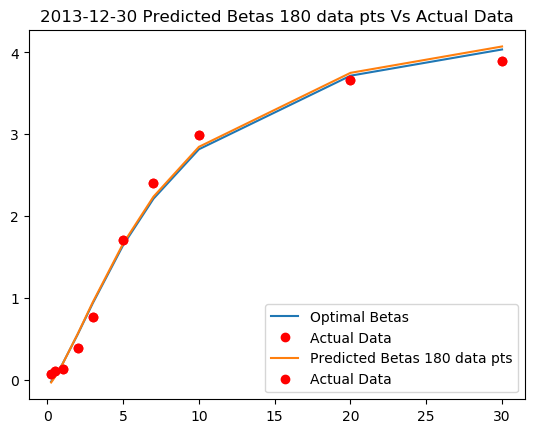

In [21]:
ns_pltcurve('2013-12-30', ns_parameters, optimal_lambda, maturity, df, 'Optimal Betas')
ns_pltcurve('2013-12-30', Predicted_beta_5d[4], optimal_lambda, maturity, df, 'Predicted Betas 180 data pts')
plt.show()

C:\Users\manaj\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


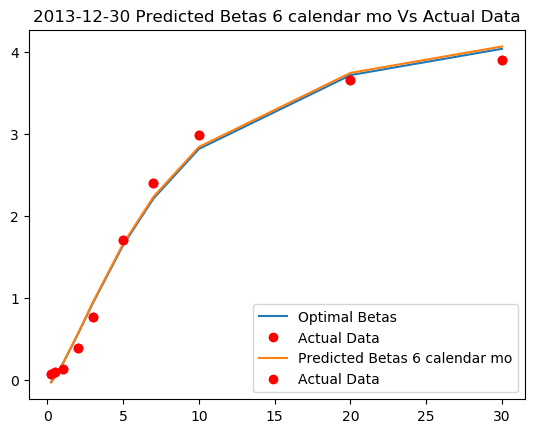

In [22]:
ns_pltcurve('2013-12-30', ns_parameters, optimal_lambda, maturity, df, 'Optimal Betas')
ns_pltcurve('2013-12-30', Predicted_beta_5d_c[4], optimal_lambda, maturity, df, 'Predicted Betas 6 calendar mo')
plt.show()

### Function that fits lag data as Random Walk:
###### To fit random walk model I use ARIMA(0,1,0) model i.e. special case of AR1 model with slope coefficient equal to 1.

In [23]:
def randomwalk_hf_fc_nsfactors(date, df_nsparameters, past_days, forcast_days):
    
    ind = np.where(df_nsparameters.index==date)
    pos = ind[0][0]
    
    hf = []
    forcast = []
    
    for ns_factor in df_nsparameters.columns[:3]:
        b = df_nsparameters.iloc[pos-past_days:pos][ns_factor]
        model = ar.ARIMA(b, order=(0,1,0)).fit()
        h = -math.log(2)/math.log(model.arparams)
        hf.append(h)
        forcast_b = model.forecast(forcast_days+1)[0]
        forcast.append(forcast_b)
    
    predicted_betas = pd.DataFrame(np.array(forcast).T)
    predicted_betas.columns = df_nsparameters.columns[:3]
    betas_index = df_nsparameters.iloc[pos:pos+forcast_days+1].index
    predicted_betas['Date'] = betas_index
    predicted_betas.set_index('Date', inplace=True)
    predicted_betas
    
    halflife = pd.DataFrame(columns=['Parameters', 'Half Life'])
    halflife['Parameters'] = df_nsparameters.columns[:3]
    halflife.set_index('Parameters', inplace = True)
    halflife['Half Life'] = hf
    
    return halflife, predicted_betas


### t+5d Half-life for 5 days using Random Walk Model

In [24]:
Predicted_beta_5d_rw = []
half_life_5_rw = []

for date in RMSE_High2low_Top5.index:
    Predicted_5_rw = AR1_hf_fc_nsfactors(date, ns_parameters, 180, 5)
    Predicted_beta_5d_rw.append(Predicted_5_rw[1])
    half_life_5_rw.append(Predicted_5_rw[0])
    
Predicted_beta_5d_rw_c = []
half_life_5_rw_c = []
for date in RMSE_High2low_Top5.index:
    Predicted_5_rw_c = AR1_hf_fc_nsfactors(date, ns_parameters, 126, 5)
    Predicted_beta_5d_rw_c.append(Predicted_5_rw_c[1])
    half_life_5_rw_c.append(Predicted_5_rw_c[0])

[print('\n 180 data points '+str(RMSE_High2low_Top5.index[i])+'\n',half_life_5_rw[i]) for i in range(0,5)]
[print('\nCalendar 6 months '+str(RMSE_High2low_Top5.index[i])+'\n', half_life_5_rw_c[i]) for i in range(0,5)]



 180 data points 2013-12-31 00:00:00
              Half Life
Parameters            
b0          126.859009
b1          139.156154
b2           16.954976

 180 data points 2013-12-24 00:00:00
              Half Life
Parameters            
b0          116.785062
b1          132.324984
b2           16.937142

 180 data points 2013-12-27 00:00:00
              Half Life
Parameters            
b0          105.778084
b1          122.561350
b2           18.140530

 180 data points 2014-01-02 00:00:00
              Half Life
Parameters            
b0          149.934950
b1          161.866876
b2           16.459938

 180 data points 2013-12-30 00:00:00
              Half Life
Parameters            
b0          111.241023
b1          128.718622
b2           17.539979

Calendar 6 months 2013-12-31 00:00:00
             Half Life
Parameters           
b0          12.634308
b1          10.602886
b2          15.467125

Calendar 6 months 2013-12-24 00:00:00
             Half Life
Parameters        

[None, None, None, None, None]

### Problem 2. Step 3. Do these forecasts perform better than those generated under a random walk assumption?

### t+5d Predicted betas for 5 days using Random Walk Model

In [25]:
[print('\n 180 data points '+str(RMSE_High2low_Top5.index[i])+'\n',Predicted_beta_5d_rw[i]) for i in range(0,5)]
[print('\nCalendar 6 months '+str(RMSE_High2low_Top5.index[i])+'\n', Predicted_beta_5d_rw_c[i]) for i in range(0,5)]


 180 data points 2013-12-31 00:00:00
                   b0        b1        b2
Date                                    
2013-12-31  4.676209 -4.752774 -3.935339
2014-01-02  4.673197 -4.749341 -3.951524
2014-01-03  4.670200 -4.745926 -3.967061
2014-01-06  4.667220 -4.742527 -3.981975
2014-01-07  4.664256 -4.739146 -3.996291
2014-01-08  4.661309 -4.735781 -4.010035

 180 data points 2013-12-24 00:00:00
                   b0        b1        b2
Date                                    
2013-12-24  4.605475 -4.681275 -3.870451
2013-12-26  4.602431 -4.677833 -3.889377
2013-12-27  4.599404 -4.674409 -3.907543
2013-12-30  4.596395 -4.671003 -3.924982
2013-12-31  4.593404 -4.667615 -3.941721
2014-01-02  4.590430 -4.664244 -3.957789

 180 data points 2013-12-27 00:00:00
                   b0        b1        b2
Date                                    
2013-12-27  4.682104 -4.773691 -3.820977
2013-12-30  4.678716 -4.769923 -3.840488
2013-12-31  4.675350 -4.766177 -3.859268
2014-01-02  4.672007 -

[None, None, None, None, None]

### Yeild Curve Predicted Betas using Random Walk Vs Predicted Betas of AR1

C:\Users\manaj\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


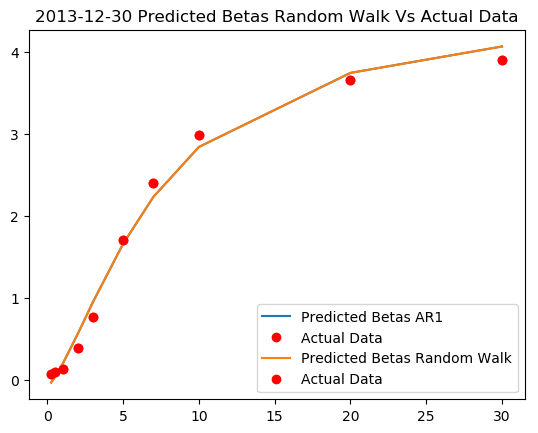

In [26]:
#ns_pltcurve('2013-12-30', ns_parameters, optimal_lambda, maturity, df, 'Optimal Betas')
ns_pltcurve('2013-12-30', Predicted_beta_5d_c[4], optimal_lambda, maturity, df, 'Predicted Betas AR1')
ns_pltcurve('2013-12-30', Predicted_beta_5d_rw_c[4], optimal_lambda, maturity, df, 'Predicted Betas Random Walk')
plt.show()

##### As seen from the above graphs  and the half-life for b0, b1, b2, it is clear that stationarity of these parameters is highly dependend on the selection of the small patch of 180 data points or 126 data points. The blue, red and red graphs correspond to 180 days and 126 days respectively. Overall time series of betas is clearly not stationary. And same is the result of AR1 model fitting, as slope coefficients of AR1 models are in the range of 0.95 to 0.99 i.e. approximately equal to 1 i.e. AR1 model with slope coefficient euqal to 1 becomes the Random walk model. This is proved in the graph above for NS with AR1 predicted parameters and NS with Random walk parameters alomst coinsides with each other. So, becasuse of non -staionarity of $\beta$s use of AR1 model does not provide any good forecasts provided by Random walk model.

### Problem 3. Fit PCA model to CMT returns using the same sample 2012-2015. Compare the in-sample explana- tory power of first 3PCAs vs $\beta_1(t); \beta_2(t); \beta3(t)$ of the DNS model. Be creative.

### Function to calculate PCA factors:

In [27]:
def PCA_manual(df):    
    c = df.cov()     
    val, vec = np.linalg.eig(c)
    decor = np.argsort(val)[::-1]
    val, vec = val[decor], vec[:, decor]
    tr = sum(val)
    var_ratio_custom = np.cumsum(np.round(val/tr, decimals=4))
    return val, vec, var_ratio_custom

### PCA Parameters or factor loading done on demean difference data

In [28]:
df1 = df.diff(periods=1).dropna()
norm = df1 -df1.mean()
print('PCA loadings(Manual):\n',PCA_manual(norm)[1])

PCA loadings(Manual):
 [[ 0.01233575 -0.03522316  0.5065613   0.4125768  -0.5024806  -0.2025303
   0.52466547 -0.04107038  0.03000406  0.02042161]
 [ 0.0169508  -0.07160778  0.57523594  0.32227626  0.01561248  0.33484134
  -0.66614062  0.00404152 -0.06078403  0.00312896]
 [ 0.0442175  -0.13545912  0.43095561 -0.03019416  0.81650218 -0.11607148
   0.32802441 -0.03334741  0.06398162  0.01034941]
 [ 0.16300775 -0.41801319  0.26316157 -0.6630375  -0.245483    0.44210009
   0.17481243  0.04476764 -0.02601005  0.02943248]
 [ 0.25360006 -0.5017714   0.0326546  -0.1071609  -0.07930413 -0.70113139
  -0.31256688  0.26828752 -0.03403518  0.05151387]
 [ 0.38588999 -0.37678877 -0.21483626  0.22206667  0.01179512  0.07833637
  -0.0170517  -0.67972769  0.25756184 -0.2805648 ]
 [ 0.44680445 -0.14606942 -0.23716024  0.32903336  0.09477881  0.24796213
   0.14867086  0.15146573 -0.40222547  0.58070914]
 [ 0.43904734  0.1044392  -0.06036315  0.15343987  0.04005756  0.17246051
   0.10486528  0.56332302  0.

### Example to illustrate the move in yield curve between $30^{th}$ and $31^{st}$ Dec. 2013  explained by PCA $1^{st}$ 3 factors and DNS model 

In [29]:
move = df.loc['2013-12-31']-data.loc['2013-12-30']
pca1 = (move-df1.mean())@PCA_manual(norm)[1][:,0]*PCA_manual(norm)[1][:,0].T+df1.mean()
pca2 = (move-df1.mean())@PCA_manual(norm)[1][:,1]*PCA_manual(norm)[1][:,1].T+pca1
pca3 = (move-df1.mean())@PCA_manual(norm)[1][:,2]*PCA_manual(norm)[1][:,2].T+pca2

In [30]:
move_ns = ns_curve('2013-12-31', ns_parameters, optimal_lambda, maturity, df) - ns_curve('2013-12-30', ns_parameters, optimal_lambda, maturity, df)


C:\Users\manaj\Anaconda3\lib\site-packages\ipykernel_launcher.py:64: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


### Plot of Actual Yeild Curve Difference Vs Explianed by 1st 3 Factors of PCA and DNS model 

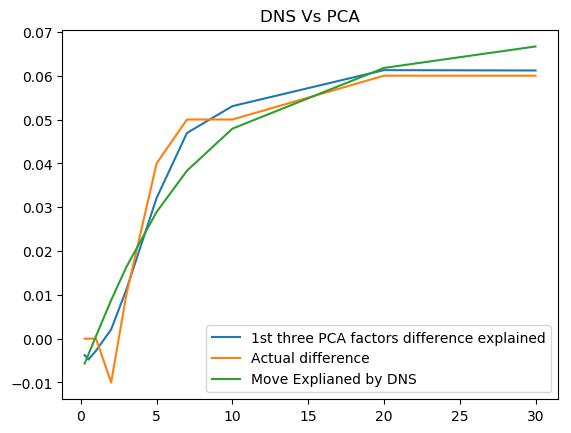

In [31]:
plt.plot(maturity, pca3, label = '1st three PCA factors difference explained')
plt.plot(maturity, move, label = 'Actual difference')
plt.plot(maturity,move_ns, label = 'Move Explianed by DNS')
plt.legend()
plt.title('DNS Vs PCA')
plt.show()

### RMSE calculation for move in Yield Curve for 30th and 31st Dec 2013

In [32]:
#PCA RMSE Calculation
pca_model_mse = mean_squared_error(move,pca3)
pca_rmse = math.sqrt(pca_model_mse)
pca_rmse

0.005257225936061775

In [33]:
#DNS RMSE calculation
DNS_model_mse = mean_squared_error(move,move_ns)
DNS_rmse = math.sqrt(DNS_model_mse)
DNS_rmse

0.008656691554320363

### Avg RMSE using PCA and DNS

In [34]:
# PCA move explianation calculation for all difference data
m1_1 = np.matrix(PCA_manual(norm)[1][:,0]).T
m1_2 = np.matrix(PCA_manual(norm)[1][:,1]).T
m1_3 = np.matrix(PCA_manual(norm)[1][:,2]).T
m2 = np.matrix(df1-df1.mean())

pca1_df = m2*m1_1*m1_1.T
pca2_df = m2*m1_2*m1_2.T
pca3_df = m2*m1_3*m1_3.T
pca_df =pd.DataFrame(pca1_df + pca2_df + pca3_df, columns=df.columns) + df1.mean()
pca_df.index = df1.index
pca_df.head()

,3 MO,6 MO,1 YR,2 YR,3 YR,5 YR,7 YR,10 YR,20 YR,30 YR
Date,,,,,,,,,,
2012-01-04,0.000067,-0.001038,-0.002814,-0.010067,-0.009414,0.003616,0.018109,0.029911,0.043968,0.046813
2012-01-05,0.007929,0.008571,0.005582,-0.000198,-0.003031,0.000326,0.007576,0.016168,0.025824,0.028647
2012-01-06,-0.005896,-0.006113,-0.005411,-0.007626,-0.010486,-0.020092,-0.028665,-0.034699,-0.041593,-0.042468
2012-01-09,-0.002194,-0.002705,-0.003395,-0.008161,-0.009682,-0.008935,-0.006628,-0.003963,-0.000705,0.000314
2012-01-10,-0.002372,-0.003070,-0.003109,-0.005412,-0.003803,0.003662,0.010543,0.015001,0.020616,0.021497


### AVG RMSE for PCA 

In [35]:
se_df1 = (pca_df - df1)**2
mse_df1 = se_df1.sum(axis = 1)
PCA_AVG_RMSE = (mse_df1.mean())**0.5
PCA_AVG_RMSE

0.02238336837538237

In [36]:
# DNS move explianation calculation for all difference data
curves_data = []
for i in range(len(df.index)):
    date= df.index[i].date()
    curves_data.append(ns_curve(date, ns_parameters, optimal_lambda, maturity, df))

C:\Users\manaj\Anaconda3\lib\site-packages\ipykernel_launcher.py:64: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


In [37]:
NS_curves_data = pd.DataFrame(curves_data, columns=df.columns)
NS_curves_data.index = df.index
NS_curves_diff = NS_curves_data.diff(periods=1).dropna()
NS_curves_diff.head()

,3 MO,6 MO,1 YR,2 YR,3 YR,5 YR,7 YR,10 YR,20 YR,30 YR
Date,,,,,,,,,,
2012-01-04,0.000658,-0.001858,-0.005176,-0.006913,-0.004755,0.004089,0.013671,0.025302,0.044069,0.050914
2012-01-05,0.006158,0.003978,0.000857,-0.001795,-0.001513,0.002763,0.008118,0.014925,0.026187,0.030322
2012-01-06,-0.004072,-0.004549,-0.005816,-0.009116,-0.012818,-0.019905,-0.025714,-0.031972,-0.041345,-0.044695
2012-01-09,-0.003855,-0.004851,-0.006362,-0.007975,-0.008402,-0.007633,-0.006218,-0.004252,-0.000856,0.000404
2012-01-10,0.001722,0.000456,-0.001263,-0.002370,-0.001609,0.002147,0.006365,0.011547,0.019965,0.023041


### AVG RMSE for DNS

In [38]:
se_NS = (NS_curves_diff - df1)**2
mse_NS = se_NS.sum(axis = 1)
NS_AVG_RMSE = (mse_NS.mean())**0.5
NS_AVG_RMSE

0.025544743230745938

##### From one sample example and AVG RMSE it seems that PCA does slightly better job of explaining change in on any given day.